# Data 

In [23]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier


In [2]:
# Load data file
df = pd.read_csv('terry-clean.csv')
pd.set_option('display.max_columns', 999)
df.head()

# Delete subject id

/Users/shirlwilliams/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,subject_age_group,subject_id,go_/_sc_num,terry_stop_id,stop_resolution,weapon_type,officer_id,officer_yob,officer_gender,officer_race,subject_perceived_race,subject_perceived_gender,reported_date,reported_time,initial_call_type,final_call_type,call_type,officer_squad,arrest_flag,frisk_flag,precinct,sector,beat
0,36 - 45,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,Asian,Male,2015-10-16T00:00:00,11:32:00,-,-,None,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,18 - 25,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,Unknown,-,2015-04-01T00:00:00,04:55:00,-,-,None,NaN,N,N,-,-,-
2,1 - 17,-1,20150000002451,46430,Field Contact,None,7591,1985,M,Hispanic or Latino,Unknown,-,2015-05-25T00:00:00,01:06:00,-,-,None,WEST PCT 3RD W - MARY,N,N,-,-,-
3,1 - 17,-1,20150000002815,51725,Field Contact,None,7456,1979,M,White,Unknown,-,2015-06-09T00:00:00,19:27:00,-,-,None,NORTH PCT 2ND W - NORA,N,N,-,-,-
4,26 - 35,-1,20150000002815,51727,Field Contact,None,7456,1979,M,White,Unknown,-,2015-06-09T00:00:00,19:32:00,-,-,None,NORTH PCT 2ND W - NORA,N,N,-,-,-


In [3]:
df.describe()

,subject_id,go_/_sc_num,terry_stop_id,officer_yob
count,4.031300e+04,4.031300e+04,4.031300e+04,40313.000000
mean,1.213040e+09,2.017155e+13,1.503510e+09,1982.277131
std,3.046154e+09,1.471057e+10,3.722270e+09,8.834036
min,-1.000000e+00,2.009000e+13,2.802000e+04,1900.000000
25%,-1.000000e+00,2.016000e+13,1.572900e+05,1977.000000
50%,-1.000000e+00,2.017000e+13,3.184670e+05,1984.000000
75%,-1.000000e+00,2.018000e+13,5.052170e+05,1989.000000
max,1.275286e+10,2.020000e+13,1.275287e+10,1997.000000


# Build a base model

First set the target: arrest flag

In [4]:
# Set target
y = df.arrest_flag
y = y.replace('N', 0).replace('Y', 1)
y.head()

0    0
1    0
2    0
3    0
4    0
Name: arrest_flag, dtype: int64

## Arrest flag is imbalanced

In [26]:
# Vies arrest flag indicator
df.arrest_flag.value_counts()

N    38707
Y     1606
Name: arrest_flag, dtype: int64

## Random Forest:
I will use a random forest with the top attributes to build a baseline model.
* frisk flag
* call type
* subject age group
* subject perceived gender
* subject perceived race
* reported time - will create categories manually

In [5]:
# Top features to try
X = df[['frisk_flag', 'call_type', 'subject_age_group', 'subject_perceived_gender', 'subject_perceived_race']]
X.head()

,frisk_flag,call_type,subject_age_group,subject_perceived_gender,subject_perceived_race
0,N,None,36 - 45,Male,Asian
1,N,None,18 - 25,-,Unknown
2,N,None,1 - 17,-,Unknown
3,N,None,1 - 17,-,Unknown
4,N,None,26 - 35,-,Unknown


### Create dummy variables

In [6]:
# Create dummy variables
data = pd.get_dummies(X)
display(data.head())


,frisk_flag_-,frisk_flag_N,frisk_flag_Y,call_type_911,call_type_None,call_type_ONVIEW,call_type_Other,subject_age_group_1 - 17,subject_age_group_18 - 25,subject_age_group_26 - 35,subject_age_group_36 - 45,subject_age_group_46 - 55,subject_age_group_56 and Above,subject_perceived_gender_-,subject_perceived_gender_Female,subject_perceived_gender_Gender Diverse (gender non-conforming and/or transgender),subject_perceived_gender_Male,subject_perceived_gender_Unable to Determine,subject_perceived_gender_Unknown,subject_perceived_race_American Indian or Alaska Native,subject_perceived_race_Asian,subject_perceived_race_Black or African American,subject_perceived_race_Hispanic,subject_perceived_race_Multi-Racial,subject_perceived_race_Native Hawaiian or Other Pacific Islander,subject_perceived_race_Other,subject_perceived_race_Unknown,subject_perceived_race_White
0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Separate reported time

In [7]:
# Observe the hour
df.reported_time = df.reported_time.str[:2].astype('int')
df.reported_time.head()


0    11
1     4
2     1
3    19
4    19
Name: reported_time, dtype: int64

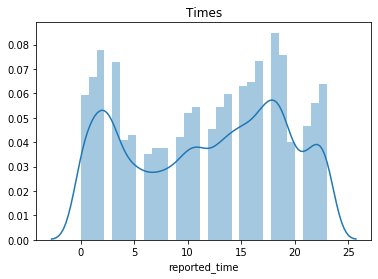

In [8]:
sns.distplot(df.reported_time)
plt.title('Times')
plt.show()

In [9]:
# Create bins
bins = [0, 6, 12, 18, 24]

# Use pd.cut()
bins_time = pd.cut(df.reported_time, bins)

# Using pd.cut() returns unordered categories. Transform to ordered.
bins_time = bins_time.cat.as_ordered() 
bins_time.head()

0     (6, 12]
1      (0, 6]
2      (0, 6]
3    (18, 24]
4    (18, 24]
Name: reported_time, dtype: category
Categories (4, interval[int64]): [(0, 6] < (6, 12] < (12, 18] < (18, 24]]

Text(0.5, 1.0, 'Time Bins')

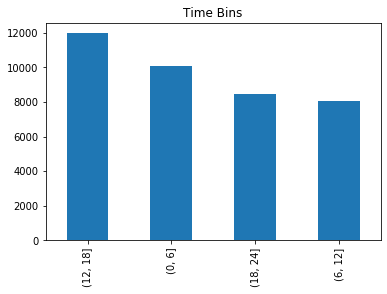

In [10]:
# Plot the values
bins_time.value_counts().plot(kind='bar')
plt.title('Time Bins')

In [11]:
# Replace the existing 
df.reported_time = bins_time

In [12]:
# Perfom label encoding
df.reported_time = df.reported_time.cat.codes
df.reported_time.head()

0    1
1    0
2    0
3    3
4    3
Name: reported_time, dtype: int8

In [13]:
# Add reported time category to other categoricals
data['reported_time'] = df.reported_time
data.head()

,frisk_flag_-,frisk_flag_N,frisk_flag_Y,call_type_911,call_type_None,call_type_ONVIEW,call_type_Other,subject_age_group_1 - 17,subject_age_group_18 - 25,subject_age_group_26 - 35,subject_age_group_36 - 45,subject_age_group_46 - 55,subject_age_group_56 and Above,subject_perceived_gender_-,subject_perceived_gender_Female,subject_perceived_gender_Gender Diverse (gender non-conforming and/or transgender),subject_perceived_gender_Male,subject_perceived_gender_Unable to Determine,subject_perceived_gender_Unknown,subject_perceived_race_American Indian or Alaska Native,subject_perceived_race_Asian,subject_perceived_race_Black or African American,subject_perceived_race_Hispanic,subject_perceived_race_Multi-Racial,subject_perceived_race_Native Hawaiian or Other Pacific Islander,subject_perceived_race_Other,subject_perceived_race_Unknown,subject_perceived_race_White,reported_time
0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3
4,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3


In [14]:
# Save the categorical data to use on other pages (notebooks)
data.to_csv('terry-cat-dummies.csv', index = False) 

## Train/test the data
Using a decision tree to create the base model and find features. 

In [14]:
# Split the train and test sets
data_train, data_test, target_train, target_test = train_test_split(data, y, 
                                                                    test_size = 0.25)

In [15]:
# Instantiate and fit a DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5) 
tree_clf.fit(data_train, target_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [16]:
# Examine feature importance
display(tree_clf.feature_importances_)

array([0.00000000e+00, 0.00000000e+00, 2.49669200e-03, 4.24286550e-02,
       6.60435945e-01, 0.00000000e+00, 0.00000000e+00, 5.24803952e-02,
       6.62793139e-02, 1.86177281e-04, 1.93325366e-03, 6.42079511e-04,
       9.09909252e-03, 0.00000000e+00, 1.98643729e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.90665462e-03, 0.00000000e+00, 9.82043956e-02, 7.25680643e-03,
       1.48525210e-02, 0.00000000e+00, 2.33068609e-04, 3.96379315e-03,
       3.56147189e-02])

## Plot the important features

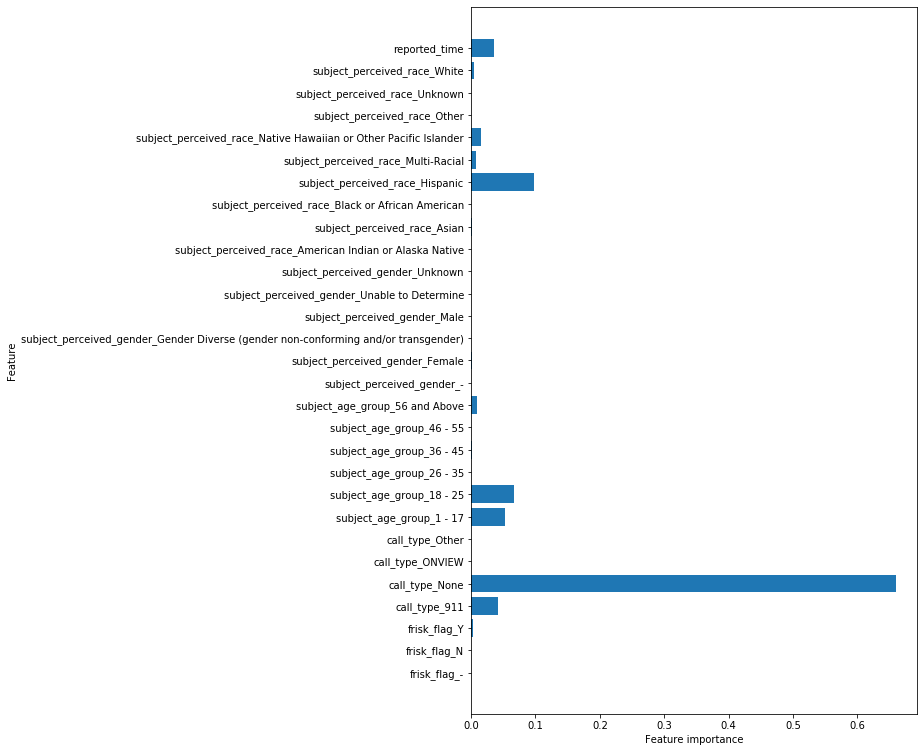

In [17]:
# Plot of the important features
def plot_feature_importances(model):
    n_features = data_train.shape[1]
    plt.figure(figsize=(8,13))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(tree_clf)


## Model Performance
Generate predictions, print out confusion matrix, and a classification report.

In [18]:
# Test set predictions
pred = tree_clf.predict(data_test)

# Confusion matrix and classification report
print(confusion_matrix(target_test, pred))
print(classification_report(target_test, pred))

[[9710    1]
 [ 368    0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9711
           1       0.00      0.00      0.00       368

    accuracy                           0.96     10079
   macro avg       0.48      0.50      0.49     10079
weighted avg       0.93      0.96      0.95     10079



In [ ]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

This model predicts all of the negatives and none of the positives. As a model it's predictive nature leaves much to be desired. 

# View a tree

In [19]:
# Needed imports
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

/Users/shirlwilliams/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [30]:
# Get a tree
tree_0 = tree_clf.estimators_[0]
tree_0

In [31]:
# Draw a tree
dot_data = StringIO()
export_graphviz(tree_0, out_file=dot_data, filled=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

# Bagged trees

In [24]:
# Instantiate a BaggingClassifier
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=20)

# Fit to training data
bagged_tree.fit(data_train, target_train)

In [25]:
# Training accuracy score
scr = bagged_tree.score(data_train, target_train)
print('Training Accuracy: ' + str(scr))

# Test accuracy score
scr = bagged_tree.score(data_test, target_test)
print('Test Accuracy: ' + str(scr))

# Random Forest Model

In [26]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(data_train, target_train)

In [27]:
# Training accuracy score
scr = forest.score(data_train, target_train)
print('Training Accuracy: ' + str(scr))

# Test accuracy score
scr = forest.score(data_test, target_test)
print('Test Accuracy: ' + str(scr))

In [28]:
# Feature Importance
plot_feature_importances(forest)

## Trees in the forest

In [29]:
# Instantiate and fit a RandomForestClassifier
forest_2 = RandomForestClassifier(n_estimators = 5, max_features= 10, max_depth= 2)
forest_2.fit(data_train, target_train)

In [ ]:
# First tree from forest_2
rf_tree_1 = forest_2.estimators_[0]

# Feature importance
plot_feature_importances(rf_tree_1)

In [ ]:
# Second tree from forest_2
rf_tree_2 = forest_2.estimators_[1]

# Feature importance
plot_feature_importances(rf_tree_2)

In [ ]:
# Third tree from forest_2
rf_tree_3 = forest_2.estimators_[2]

# Feature importance
plot_feature_importances(rf_tree_3)

In [ ]:
# Fourth tree from forest_2
rf_tree_4 = forest_2.estimators_[3]

# Feature importance
plot_feature_importances(rf_tree_4)

In [ ]:
# Fifth tree from forest_2
rf_tree_5 = forest_2.estimators_[4]

# Feature importance
plot_feature_importances(rf_tree_5)

# Logistic Regression Model
Since we have class imbalance with None to everything else, let's try the Logistic Regression Model.

In [28]:
# Find class imbalance in the training and test sets
print(target_train.value_counts())
print(target_test.value_counts())

0    28996
1     1238
Name: arrest_flag, dtype: int64
0    9711
1     368
Name: arrest_flag, dtype: int64


AUC: 0.7070395573374881


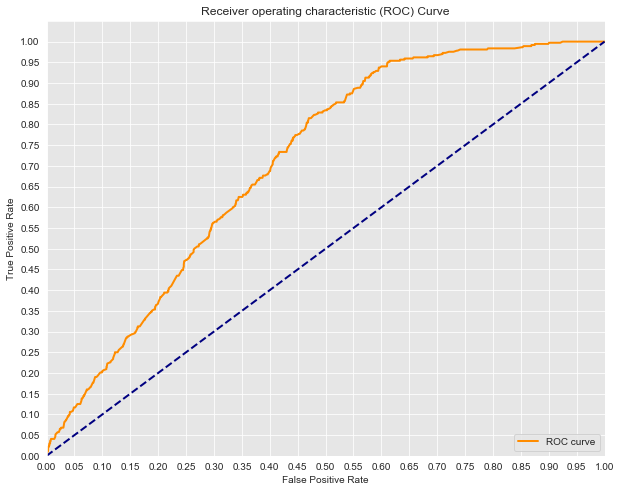

In [30]:
# Initial Logistic Model
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')

# Probability scores for test set
target_score = logreg.fit(data_train, target_train).decision_function(data_test)

# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(target_test, target_score)

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [31]:
# Plot a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[9711  368]
 [   0    0]]


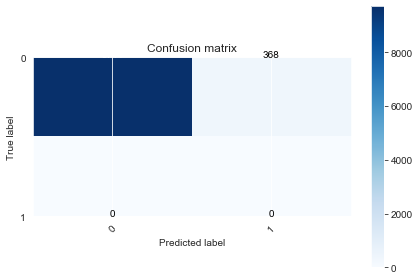

In [32]:
# Plot confusion matrix of the test set 
target_hat_test = logreg.predict(data_test)
cnf_matrix = confusion_matrix(target_hat_test, target_test)
plot_confusion_matrix(cnf_matrix, classes=[0, 1])

# Tune the model
Trying various techniques to tune the model.

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.001: 0.5609112872896267
-------------------------------------------------------
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.01: 0.6652749515341186
-------------------------------------------------------
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
         

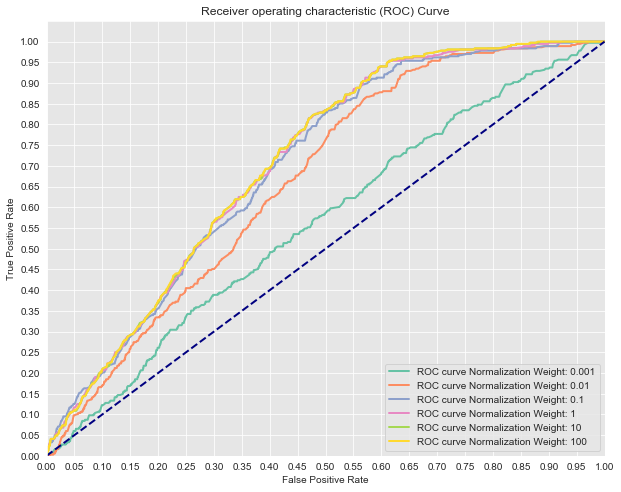

In [33]:
# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.001, 0.01, 0.1, 1, 10, 100]
names = [0.001, 0.01, 0.1, 1, 10, 100]
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(data_train, target_train)
    print(model_log) # Preview model params

    # Predict
    target_hat_test = logreg.predict(data_test)

    target_score = logreg.fit(data_train, target_train).decision_function(data_test)

    fpr, tpr, thresholds = roc_curve(target_test, target_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## SMOTE
Will use the Smote class from the imblearn package to improve the model's performance on the minority class.

In [34]:
# Previous original class distribution
print(target_train.value_counts()) 

# Fit SMOTE to training data
data_train_resampled, target_train_resampled = SMOTE().fit_sample(data_train, target_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(target_train_resampled).value_counts()) 

0    28996
1     1238
Name: arrest_flag, dtype: int64


1    28996
0    28996
dtype: int64


## Build modes with resampled training data:

LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.005: 0.6953456244151635
-------------------------------------------------------
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.1: 0.6966054015392674
-------------------------------------------------------
LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
           

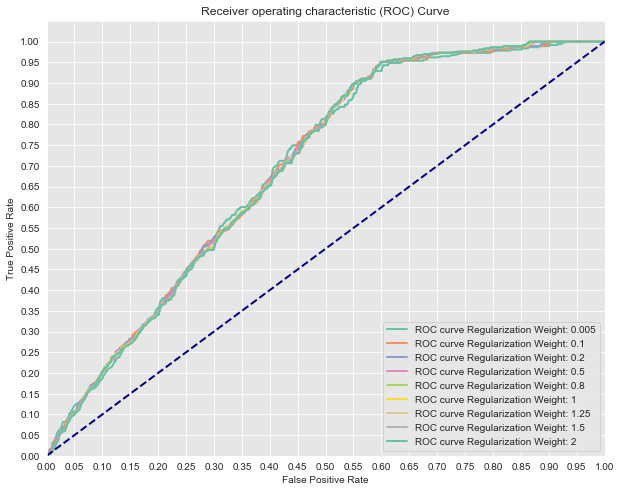

In [35]:
# Now let's compare a few different regularization performances on the dataset
C_param_range = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
names = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(data_train_resampled, target_train_resampled)
    print(model_log) # Preview model params

    # Predict
    target_hat_test = logreg.predict(data_test)

    target_score = logreg.fit(data_train_resampled, target_train_resampled).decision_function(data_test)

    fpr, tpr, thresholds = roc_curve(target_test, target_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## The models don't support prediction.

### Summary
Significant features contributing to the model:
* Call type None is the only significant feature.
Other features with minor implications may be:
* Call type 911
* Subject age group 18 - 25
* Subject perceived race Hispanic